In [1]:
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, UnstructuredExcelLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain_core.utils.function_calling import convert_to_openai_function
from operator import itemgetter
from pydantic import BaseModel
from typing import Literal
from langchain.chains import ConversationChain
from utils.google_calendar import get_available_slots, crear_evento, borrar_evento

llm bootcamp
check!


In [2]:
import os, sys
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
print(os.environ['LANGCHAIN_PROJECT'])

llm bootcamp


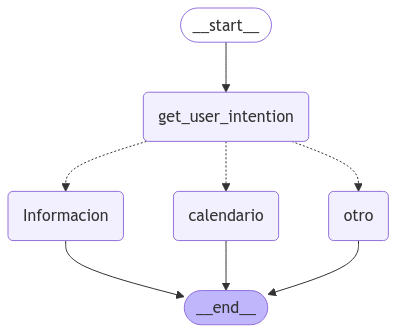

In [77]:
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model="gpt-3.5-turbo")

class ChatBotState(MessagesState):
    Intention : str
    on_calendar_node : bool = False
    n_otro : int = 0

class Intention(BaseModel):
    intention : Literal["Informacion", "calendario", "otro"] = Field(description="La intención que se saca del mensaje que da el usuario humano. Se tiene que clasificar entre información o calendario")

INTENTION_MESSAGE = "Eres un asistente en de una farmacia y tu objetivo es ayudar a los clientes a despejar sus dudas. Entre tus funciones está resolver dudas relacionadas con el tema, así como gestionar citas para una reunión en persona con uno de nuestros farmaceúticos. Para poder ayudar mejor, tu tarea va a ser clasificar la intención del usuario entre las \
siguientes opciones : \
   1. Información -> en caso de que necesite saber u obtener consejo sobre la farmacia. Por ejemplo: el usuario quiere saber que dias hacemos guardias \
   2. Calendario: El usuario quiere agendar una cita \
   3. Otro: Esta hablando sobre un tema que no está relacionada con la farmacia."



def get_user_intention(state: ChatBotState):
    llm_with_structured_output = llm.with_structured_output(Intention)
    response = llm_with_structured_output.invoke([AIMessage(INTENTION_MESSAGE)] + state['messages'])
    return {'messages':AIMessage(response.intention),'intention': response.intention}

def router(state: ChatBotState):
    intent = state['intention']
    return intent

def node_info(state:ChatBotState):
    print('----INFO----')
    return {'messages': AIMessage('Aquí')}

def node_calendario(state:ChatBotState):
    print('----CALENDARIO-----')
    return

def node_otro(state:ChatBotState):
    print('----OTRO-----')
    return

builder = StateGraph(ChatBotState)
builder.add_node('get_user_intention', get_user_intention)
builder.add_node('Informacion', node_info)
builder.add_node('calendario', node_calendario)
builder.add_node('otro', node_otro)

builder.add_edge(START, 'get_user_intention')
builder.add_conditional_edges('get_user_intention', router, ['Informacion', 'calendario', 'otro'])
builder.add_edge('Informacion', END)
builder.add_edge('calendario', END)
builder.add_edge('otro', END)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
from datetime import datetime
from langgraph.prebuilt import ToolNode, tools_condition

current_year = datetime.today().year
class CalendarState(MessagesState):
    Preferred_date: str = None

class Calendarday(BaseModel):
    day : datetime = Field(description="La fecha para agendar una cita")

class isCalendarday(BaseModel):
    is_calendarday : bool =Field(description="True el usuario ha mencionado una fecha para agendar o False en caso contrario")
    day : datetime = Field(description="La fecha para agendar una cita", default=None)


sys_calendar_message = """Eres un asistente que se encarga de agendar citas. De la conversación debes extraer la fecha preferida por el cliente. En caso de no haber fecha propuesta aún no la inventes.Pidele la fecha que prefiere para agendar una cita"""


def agendar_cita(state:CalendarState):
    return f"agendado en:{state.Preferred_date}"

def get_preferred_day(state: CalendarState):
    llm_with_structured_output = llm.with_structured_output(isCalendarday)
    response = llm_with_structured_output.invoke([SystemMessage(sys_calendar_message)] + state["messages"])
    return {"Preferred_date":response.day}

def need_day(state:CalendarState):
    response=llm.invoke("El cliente aún no ha proporcionado una fecha.Necesito que le pidas una fecha y hora para agendar la cita")
    return response

def create_event(state:CalendarState):
    if state.day:
        end_date = state.day =datetime.timedelta(minutes=30)
        evento = crear_evento(state.day, end_time=end_date)
        if evento:
           #status = f'reserva exitosa: {state.day.strftime('%Y-%m-%d %H:%M')}'
    else:
        status = "No se ha especificado que fecha prefiere el cliente para agendar cita"

    system_messagge = AIMessage(content=f"Te encargar de gestionar las citas en el calendario. Neceistas dar al cliente una respuesta teniendo en cuenta el estatus: {status}")
    llm.invoke

 

IndentationError: expected an indented block after 'if' statement on line 35 (3549081820.py, line 37)

In [73]:
from datetime import datetime
from datetime import timedelta
from langgraph.prebuilt import ToolNode, tools_condition


def tool_get_available_slots():
    """Herramienta para ofrecer tres huecos libres en la agenda para que el cliente decida entre uno de ellos
    para agendar una cita"""
    return get_available_slots()

def tool_crear_evento(start_time:datetime):
    """Herramienta que se usa para agendar una cita en el slot dado
    Args:
    start_time: fecha de comienzo"""
    end_time = start_time +timedelta(minutes=30)
    response = crear_evento(start_time=start_time, end_time=end_time)
    if response:
        return "Reserva exitosa"
        
    else:
        return "No fue posible realizar la reserva"
    
tools = [tool_get_available_slots, tool_crear_evento]
    
sys_msg = "Eres un asistente que se encargar de agendar las citas. Debes ayudar al cliente ofreciendole huecos disponibles y reservando en el hueco que te diga\
          Usa la conversación para identificar la fecha que quiere agendar el usuario"

def assistant(state:ChatBotState):
    llm_with_tools = llm.bind_tools(tools=tools)
    response = llm_with_tools.invoke([SystemMessage(content=sys_msg)] + state['messages'])
    return {'messages':response}

builder = StateGraph(ChatBotState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
calendar_graph = builder.compile(checkpointer=memory)




In [58]:
config ={ "configurable": {"thread_id": "1"}}
for event in graph.stream({"messages": "Me gustaría saber que horario tiene la farmacia. Abre los domingos?"}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Me gustaría saber que horario tiene la farmacia. Abre los domingos?
================================== Ai Message ==================================

¡Hola! Déjame verificar la disponibilidad de la farmacia. Solo necesito un momento para obtener esa información.
Tool Calls:
  tool_get_available_slots (call_I2yKkBPntu63piel1pu6BoXz)
 Call ID: call_I2yKkBPntu63piel1pu6BoXz
  Args:
eventos escaneados
================================= Tool Message =================================
Name: tool_get_available_slots

[(datetime.datetime(2025, 2, 3, 17, 30, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'Hora estándar romance')), datetime.datetime(2025, 2, 3, 18, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'Hora estándar romance'))), (datetime.datetime(2025, 2, 4, 10, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'Hora estándar romance')), datetime.datetime(2025, 2, 4, 

In [59]:
for event in graph.stream({"messages": "La opción 2 por favor"},config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

La opción 2 por favor
================================== Ai Message ==================================
Tool Calls:
  tool_crear_evento (call_9f70r05Fp88IoGgH9M6RLUZB)
 Call ID: call_9f70r05Fp88IoGgH9M6RLUZB
  Args:
    start_time: 2025-02-04T10:00:00
Evento creado: https://www.google.com/calendar/event?eid=b2lnM3U5dm5uZGluMXJoZGhwcHBpaXFuNTQgamFyYWl6MzdAbQ
================================= Tool Message =================================
Name: tool_crear_evento

Reserva exitosa
================================== Ai Message ==================================

¡La cita en la farmacia para el 4 de Febrero de 2025 a las 10:00 ha sido agendada con éxito! ¿Hay algo más en lo que pueda ayudarte?


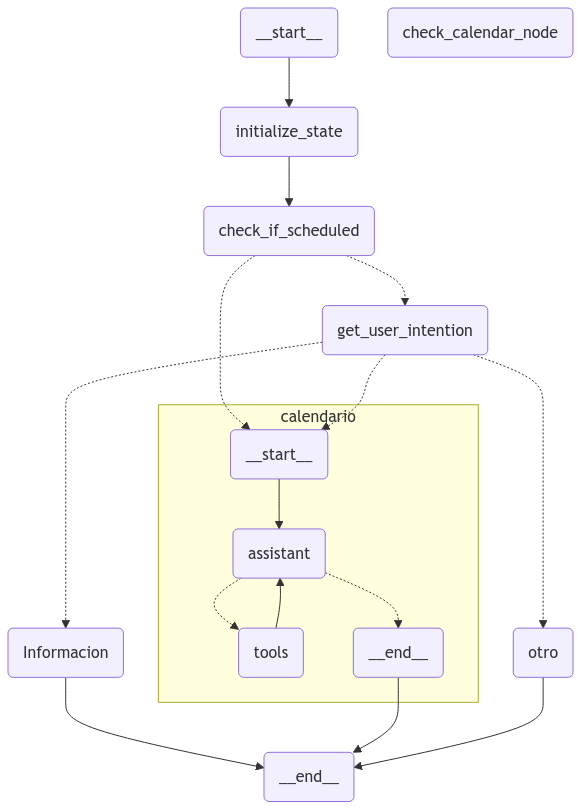

In [124]:
class Intention(BaseModel):
    intention : Literal["Informacion", "calendario", "otro"] = Field(description="La intención que se saca del mensaje que da el usuario humano. Se tiene que clasificar entre información o calendario")

INTENTION_MESSAGE = "Eres un asistente en de una farmacia y tu objetivo es ayudar a los clientes a despejar sus dudas. Entre tus funciones está resolver dudas relacionadas con el tema, así como gestionar citas para una reunión en persona con uno de nuestros farmaceúticos. Para poder ayudar mejor, tu tarea va a ser clasificar la intención del usuario entre las \
siguientes opciones : \
   1. Información -> en caso de que necesite saber u obtener consejo sobre la farmacia. Por ejemplo: el usuario quiere saber que dias hacemos guardias \
   2. Calendario: El usuario quiere agendar una cita \
   3. Otro: Esta hablando sobre un tema que no está relacionada con la farmacia."

class IsScheduled(BaseModel):
    schedule: bool = Field(description="Verdader si ya se ha realizado la reserva de la cita. En caso contrario  Falso",default=False)

class ChatBotState(MessagesState):
    Intention : str
    on_calendar_node : bool = Field(default=False, description="Indica si se está en el nodo de calendario.")
    n_otro: int = Field(default=0, description="Contador para otros temas no relacionados.")



def initialize_state(state:ChatBotState):
    n_messages = len(state['messages'])
    if n_messages < 2:
        print('here')
        return {"n_otro":0, "on_calendar_node":False}
    return

def check_if_scheduled(state:ChatBotState):
    sys_msg = "Identifica en la conversación si se ha realizado una reserva"
    llm_with_structured_output = llm.with_structured_output(IsScheduled)
    response = llm_with_structured_output.invoke([SystemMessage(content=sys_msg)] + state['messages'])
    if response.schedule:
        print('there´s response')
        return {'on_calendar_node':False}
    return



def get_user_intention(state: ChatBotState):
    llm_with_structured_output = llm.with_structured_output(Intention)
    response = llm_with_structured_output.invoke([AIMessage(INTENTION_MESSAGE)] + state['messages'])
    return {'messages':AIMessage(response.intention),'intention': response.intention}

def router(state: ChatBotState):
    intent = state['intention']
    if intent=="calendario":
        state["on_calendar_node"] = True
    elif intent=="otro":
        state['n_otro'] += 1
    return intent

def check_calendar_node(state: ChatBotState):
    if state["on_calendar_node"]:
        return "calendario"
    else:
       return "get_user_intention"
    
def get_user_intention(state: ChatBotState):
    llm_with_structured_output = llm.with_structured_output(Intention)
    response = llm_with_structured_output.invoke([AIMessage(INTENTION_MESSAGE)] + state['messages'])
    return {'messages':AIMessage(response.intention),'intention': response.intention}


def node_otro(state: ChatBotState):
    if state['n_otro'] < 3:
        new_otro= state['n_otro'] + 1
        return {"messages":AIMessage("Lo siento no estoy para responder sobre temas que no están relacionados con la farmacia. ¿Le puedo ayudar en algo más?"), 'n_otro':new_otro}
    else:
        return {"messages":AIMessage(content="Adios!")}
    
def node_info(state: ChatBotState):
    return {"messages": "comprobando informacion"}
                
builder = StateGraph(ChatBotState)
builder.add_node("initialize_state", initialize_state)
builder.add_node("check_if_scheduled", check_if_scheduled)
builder.add_node("check_calendar_node", check_calendar_node)
builder.add_node("get_user_intention", get_user_intention)
builder.add_node("calendario", calendar_graph)
builder.add_node("Informacion", node_info)
builder.add_node("otro", node_otro)

builder.add_edge(START, "initialize_state")
builder.add_edge("initialize_state", "check_if_scheduled")
builder.add_conditional_edges("check_if_scheduled", check_calendar_node, ["calendario", "get_user_intention"])
builder.add_conditional_edges("get_user_intention", router, ["calendario", "otro", "Informacion"])
builder.add_edge("calendario", END)
builder.add_edge("otro", END)
builder.add_edge("Informacion", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
                              
                              




In [84]:
message = "hola, hasta cuando está abierta la farmacia?"
for event in graph.stream({"messages": message},config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

hola, hasta cuando está abierta la farmacia?
================================ Human Message =================================

hola, hasta cuando está abierta la farmacia?
================================== Ai Message ==================================

Informacion
================================ Human Message =================================

comprobando informacion


In [85]:
message = "me gustaría quedar con el farmaceútico"
for event in graph.stream({"messages": message},config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

me gustaría quedar con el farmaceútico
================================ Human Message =================================

me gustaría quedar con el farmaceútico
================================== Ai Message ==================================

calendario
eventos escaneados
================================== Ai Message ==================================

Tengo los siguientes horarios disponibles para que puedas quedar con el farmacéutico:
1. 3 de Febrero a las 14:00
2. 4 de Febrero a las 17:00
3. 4 de Febrero a las 3:30

¿En cuál de estos horarios te gustaría agendar la cita?


In [86]:
message = "me viene mejor la primera opcion"
for event in graph.stream({"messages": message},config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

me viene mejor la primera opcion
================================ Human Message =================================

me viene mejor la primera opcion
================================== Ai Message ==================================

calendario
Evento creado: https://www.google.com/calendar/event?eid=aGZjMGU3czE4MmdscWdpcWFyazl0YTRzNDQgamFyYWl6MzdAbQ
================================== Ai Message ==================================

La cita con el farmacéutico el día 3 de Febrero a las 14:00 ha sido reservada con éxito. ¡Gracias por agendarla! ¿Hay algo más en lo que pueda ayudarte?


In [126]:
message = "como te llamas?"
for event in graph.stream({"messages": message},config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

como te llamas?
================================== Ai Message ==================================

otro
================================== Ai Message ==================================

Lo siento no estoy para responder sobre temas que no están relacionados con la farmacia. ¿Le puedo ayudar en algo más?
